In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License

# Imports and Functions

In [ ]:
import numpy as np
from scipy.stats import special_ortho_group
from scipy.spatial.transform import Rotation
from scipy.linalg import svd
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
FIGURE_SCALE = 1.0
FONT_SIZE = 20
plt.rcParams.update({
    'figure.figsize': np.array((8, 6)) * FIGURE_SCALE,
    'axes.labelsize': FONT_SIZE,
    'axes.titlesize': FONT_SIZE,
    'xtick.labelsize': FONT_SIZE,
    'ytick.labelsize': FONT_SIZE,
    'legend.fontsize': FONT_SIZE,
    'lines.linewidth': 3,
    'lines.markersize': 10,
})

In [ ]:
def SO3_via_svd(A):
  """Map 3x3 matrix onto SO(3) via SVD."""
  u, s, vt = np.linalg.svd(A)
  s_SO3 = [1, 1, np.sign(np.linalg.det(np.matmul(u, vt)))]
  return np.matmul(np.matmul(u, np.diag(s_SO3)), vt)

In [ ]:
def SO3_via_gramschmidt(A):
  """Map 3x3 matrix on SO(3) via GS, ignores last column."""
  x_normalized = A[:, 0] / np.linalg.norm(A[:, 0])
  z = np.cross(x_normalized, A[:, 1])
  z_normalized = z / np.linalg.norm(z)
  y_normalized = np.cross(z_normalized, x_normalized)
  return np.stack([x_normalized, y_normalized, z_normalized], axis=1)

In [ ]:
def rotate_from_z(v):
  """Construct a rotation matrix R such that R * [0,0,||v||]^T = v.

  Input v is shape (3,), output shape is 3x3 """
  vn = v / np.linalg.norm(v)
  theta = np.arccos(vn[2])
  phi = np.arctan2(vn[1], vn[0])
  r = Rotation.from_euler('zyz', [0, theta, phi])
  R = np.squeeze(r.as_dcm()) # Maps Z to vn
  return R

def perturb_rotation_matrix(R, kappa):
  """Perturb a random rotation matrix with noise.

  Noise is random small rotation applied to each of the three
  column vectors of R. Angle of rotation is sampled from the
  von-Mises distribution on the circle (with uniform random azimuth).

  The von-Mises distribution is analagous to Gaussian distribution on the circle.
  Note, the concentration parameter kappa is inversely related to variance,
  so higher kappa means less variance, less noise applied. Good ranges for
  kappa are 64 (high noise) up to 512 (low noise).
  """
  R_perturb = []
  theta = np.random.vonmises(mu=0.0, kappa=kappa, size=(3,))
  phi = np.random.uniform(low=0.0, high=np.pi*2.0, size=(3,))
  for i in range(3):
    v = R[:, i]
    R_z_to_v = rotate_from_z(v)
    r_noise_z = np.squeeze(Rotation.from_euler('zyz', [0, theta[i], phi[i]]).as_dcm())

    v_perturb = np.matmul(R_z_to_v, np.matmul(r_noise_z, np.array([0,0,1])))
    R_perturb.append(v_perturb)

  R_perturb = np.stack(R_perturb, axis=-1)
  return R_perturb


def sigma_to_kappa(sigma):
  return ((0.5 - sigma) * 1024) + 64


In [ ]:
# We create a ground truth special orthogonal matrix and perturb it with
# additive noise. We then see which orthogonalization process (SVD or GS) is
# better at recovering the ground truth matrix.


def run_expt(sigmas, num_trials, noise_type='gaussian'):
  # Always use identity as ground truth, or pick random matrix.
  # Nothing should change if we pick random (can verify by setting to True) since
  # SVD and Gram-Schmidt are both Equivariant to rotations.
  pick_random_ground_truth=False

  all_errs_svd = []
  all_errs_gs = []
  all_geo_errs_svd = []
  all_geo_errs_gs = []
  all_noise_norms = []
  all_noise_sq_norms = []

  for sig in sigmas:
    svd_errors = np.zeros(num_trials)
    gs_errors = np.zeros(num_trials)
    svd_geo_errors = np.zeros(num_trials)
    gs_geo_errors = np.zeros(num_trials)
    noise_norms = np.zeros(num_trials)
    noise_sq_norms = np.zeros(num_trials)

    for t in range(num_trials):
      if pick_random_ground_truth:
        A = special_ortho_group.rvs(3)  # Pick a random ground truth matrix
      else:
        A = np.eye(3)  # Our ground truth matrix in SO(3)

      N = None
      if noise_type == 'gaussian':
        N = np.random.standard_normal(size=(3,3)) * sig
      if noise_type == 'uniform':
        N = np.random.uniform(-1, 1, (3, 3)) * sig
      if noise_type == 'rademacher':
        N = np.sign(np.random.uniform(-1, 1, (3, 3))) * sig
      if noise_type == 'rotation':
        A_perturb = perturb_rotation_matrix(A, kappa=sigma_to_kappa(sig))
        N = A_perturb - A
      if N is None:
        print ('Error: unknown noise_type: %s', noise_type)
        return

      AplusN = A + N  # Ground-truth plus noise
      noise_norm = np.linalg.norm(N)
      noise_norm_sq = noise_norm**2

      # Compute SVD result and error.
      res_svd = SO3_via_svd(AplusN)
      error_svd = np.linalg.norm(res_svd - A, ord='fro')**2
      error_geodesic_svd = np.arccos(
          (np.trace(np.matmul(np.transpose(res_svd), A))-1.0)/2.0);

      # Compute GS result and error.
      res_gs = SO3_via_gramschmidt(AplusN)
      error_gs = np.linalg.norm(res_gs - A, ord='fro')**2
      error_geodesic_gs = np.arccos(
          (np.trace(np.matmul(np.transpose(res_gs), A))-1.0)/2.0);

      svd_errors[t] = error_svd
      gs_errors[t] = error_gs
      svd_geo_errors[t] = error_geodesic_svd
      gs_geo_errors[t] = error_geodesic_gs
      noise_norms[t] = noise_norm
      noise_sq_norms[t] = noise_norm_sq

    all_errs_svd.append(svd_errors)
    all_errs_gs.append(gs_errors)
    all_geo_errs_svd.append(svd_geo_errors)
    all_geo_errs_gs.append(gs_geo_errors)
    all_noise_norms.append(noise_norms)
    all_noise_sq_norms.append(noise_sq_norms)
    print('finished sigma = %f / kappa = %f' % (sig, sigma_to_kappa(sig)))

  return [np.array(x) for x in (
      all_errs_svd, all_errs_gs,
      all_geo_errs_svd, all_geo_errs_gs,
      all_noise_norms, all_noise_sq_norms)]

In [ ]:
boxprops = dict(linewidth=2)
medianprops = dict(linewidth=2)
whiskerprops = dict(linewidth=2)
capprops = dict(linewidth=2)

def make_diff_plot(svd_errs, gs_errs, xvalues, title='', ytitle='', xtitle=''):
  plt.figure(figsize=(8,6))
  plt.title(title, fontsize=16)
  diff = gs_errs - svd_errs
  step_size = np.abs(xvalues[1] - xvalues[0])
  plt.boxplot(diff.T, positions=xvalues, widths=step_size/2, whis=[5, 95],
              boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops,
              showmeans=False, meanline=True, showfliers=False)
  plt.plot(xvalues, np.max(diff, axis=1), 'kx', markeredgewidth=2)
  plt.plot(xvalues, np.min(diff, axis=1), 'kx', markeredgewidth=2)
  xlim = [np.min(xvalues) - (step_size / 3), np.max(xvalues) + (step_size / 3)]
  plt.xlim(xlim)
  plt.plot(xlim, [0, 0], 'k--', linewidth=1)
  plt.xlabel(xtitle, fontsize=16)
  plt.ylabel(ytitle, fontsize=16)
  plt.tight_layout()

# Global Params

In [ ]:
num_trials = 100000  # Num trials at each sigma
sigmas = np.linspace(0.125, 0.5, 4)

# Gaussian Noise
Here we generate a noise matrix with iid Gaussian entries drawn from
$\sigma N(0,1)$.

The "Frobenius Error Diff" shows the distributions of the error differences
$\|A - \textrm{GS}(\tilde A)\|_F^2 - \|A - \textrm{SVD}(\tilde A)\|_F^2$ for
different values of $\sigma$. The "Geodesic Error Diff" plot shows the
analagous data, but in terms of the geodesic error.

In [ ]:
(all_errs_svd, all_errs_gs,
 all_geo_errs_svd, all_geo_errs_gs,
 all_noise_norms, all_noise_sq_norms
 ) = run_expt(sigmas, num_trials, noise_type='gaussian')

finished sigma = 0.125000 / kappa = 448.000000
finished sigma = 0.250000 / kappa = 320.000000
finished sigma = 0.375000 / kappa = 192.000000
finished sigma = 0.500000 / kappa = 64.000000


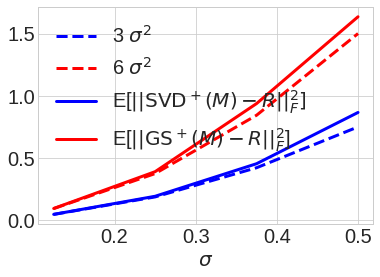

In [ ]:
plt.plot(sigmas,
         3*sigmas**2,
         '--b',
         label='3 $\\sigma^2$')
plt.errorbar(sigmas,
             all_errs_svd.mean(axis=1),
             color='b',
             label='E[$\\|\\|\\mathrm{SVD}^+(M) - R\\|\\|_F^2]$')

plt.plot(sigmas, 6*sigmas**2,
         '--r',
         label='6 $\\sigma^2$')
plt.errorbar(sigmas,
             all_errs_gs.mean(axis=1),
             color='r',
             label='E[$\\|\\|\\mathrm{GS}^+(M) - R\\|\\|_F^2$]')

plt.xlabel('$\\sigma$')
plt.legend(loc='upper left')

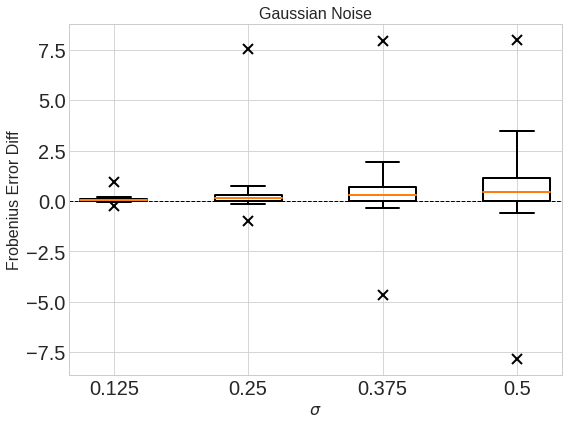

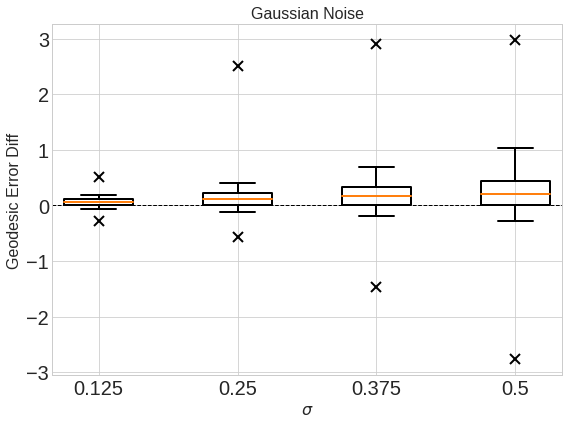

In [ ]:
make_diff_plot(all_errs_svd, all_errs_gs, sigmas, title='Gaussian Noise', ytitle='Frobenius Error Diff', xtitle='$\\sigma$')
make_diff_plot(all_geo_errs_svd, all_geo_errs_gs, sigmas, title='Gaussian Noise', ytitle='Geodesic Error Diff', xtitle='$\\sigma$')

# Uniform Noise
Here, the noise matrix is constructed with iid entries drawn from $\sigma \textrm{Unif}(-1, 1)$.

In [ ]:
(all_errs_svd, all_errs_gs,
 all_geo_errs_svd, all_geo_errs_gs,
 all_noise_norms, all_noise_sq_norms
 ) = run_expt(sigmas, num_trials, noise_type='uniform')

finished sigma = 0.125000 / kappa = 448.000000
finished sigma = 0.250000 / kappa = 320.000000
finished sigma = 0.375000 / kappa = 192.000000
finished sigma = 0.500000 / kappa = 64.000000


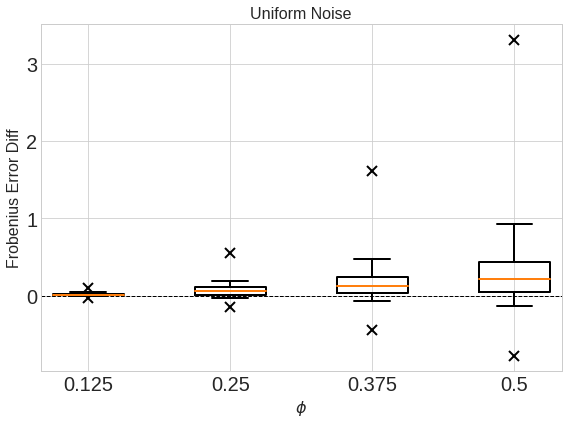

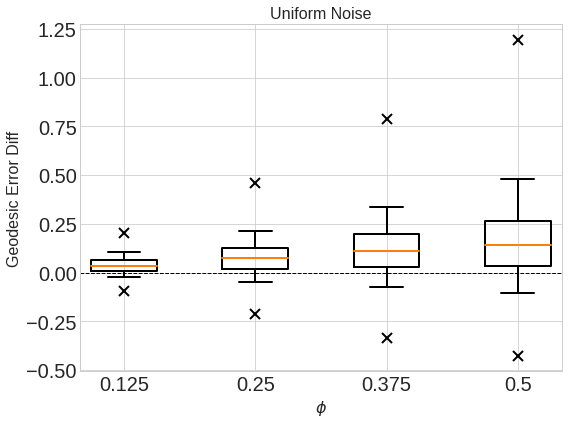

In [ ]:
make_diff_plot(all_errs_svd, all_errs_gs, sigmas, title='Uniform Noise', ytitle='Frobenius Error Diff', xtitle='$\\phi$')
make_diff_plot(all_geo_errs_svd, all_geo_errs_gs, sigmas, title='Uniform Noise', ytitle='Geodesic Error Diff', xtitle='$\\phi$')

#Rotation Noise

In [ ]:
(all_errs_svd, all_errs_gs,
 all_geo_errs_svd, all_geo_errs_gs,
 all_noise_norms, all_noise_sq_norms
 ) = run_expt(sigmas, num_trials, noise_type='rotation')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `as_dcm` is deprecated!
as_dcm is renamed to as_matrix in scipy 1.4.0 and will be removed in scipy 1.6.0
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `as_dcm` is deprecated!
as_dcm is renamed to as_matrix in scipy 1.4.0 and will be removed in scipy 1.6.0


finished sigma = 0.125000 / kappa = 448.000000
finished sigma = 0.250000 / kappa = 320.000000
finished sigma = 0.375000 / kappa = 192.000000
finished sigma = 0.500000 / kappa = 64.000000


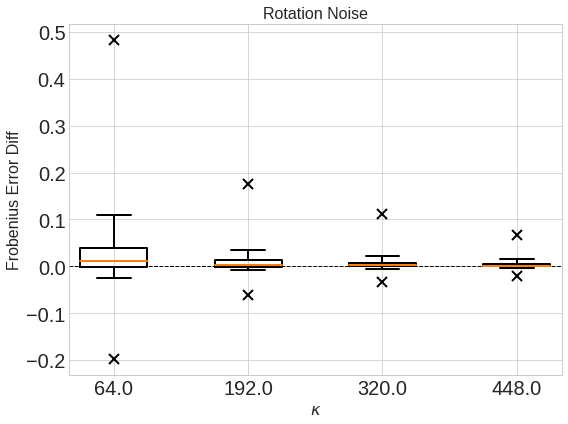

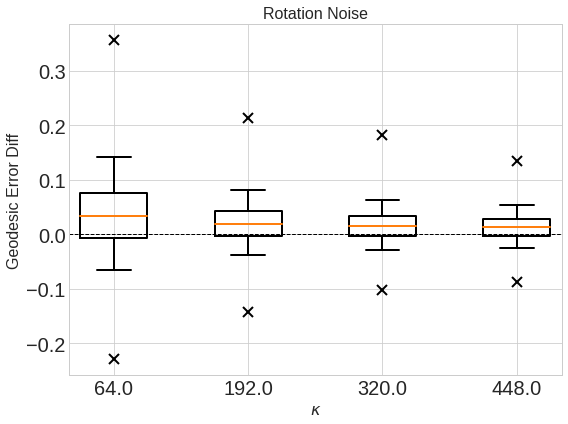

In [ ]:
make_diff_plot(all_errs_svd, all_errs_gs, sigma_to_kappa(sigmas), title='Rotation Noise', ytitle='Frobenius Error Diff', xtitle='$\\kappa$')
make_diff_plot(all_geo_errs_svd, all_geo_errs_gs, sigma_to_kappa(sigmas), title='Rotation Noise', ytitle='Geodesic Error Diff', xtitle='$\\kappa$')